In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os


alerts_df3 = pd.read_csv("./combined_status_tracker.csv")
#print(alerts_df3)

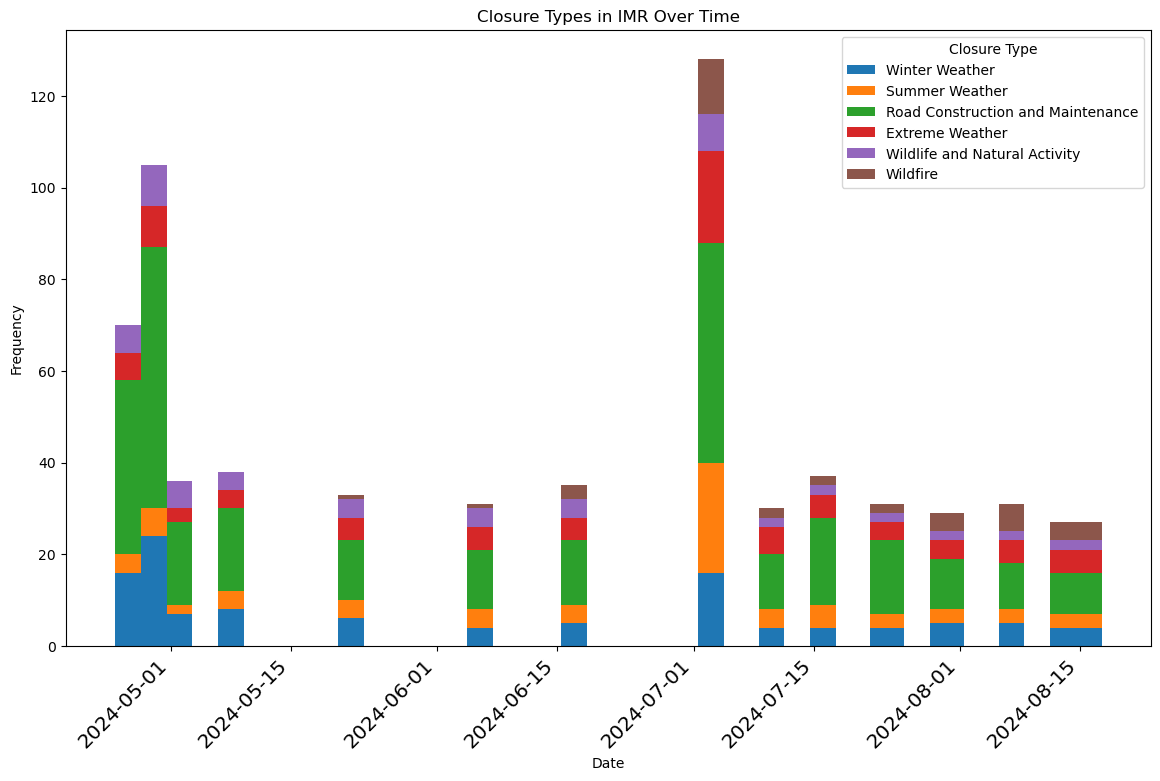

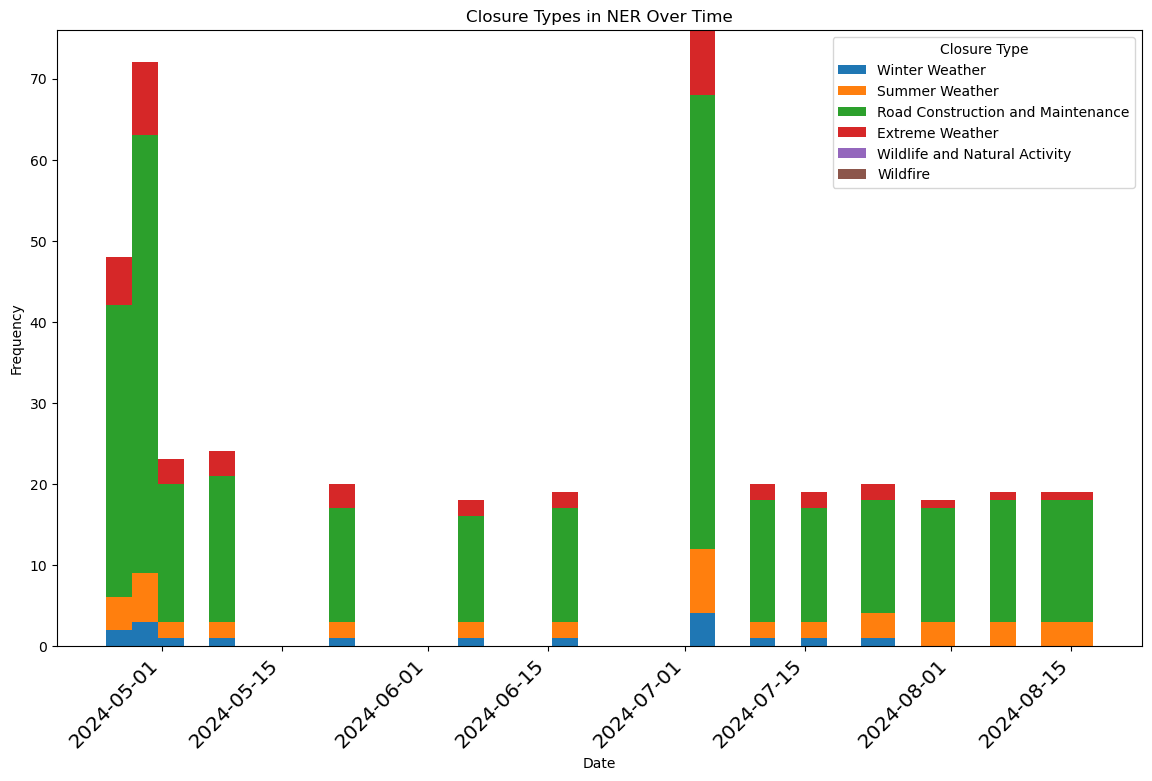

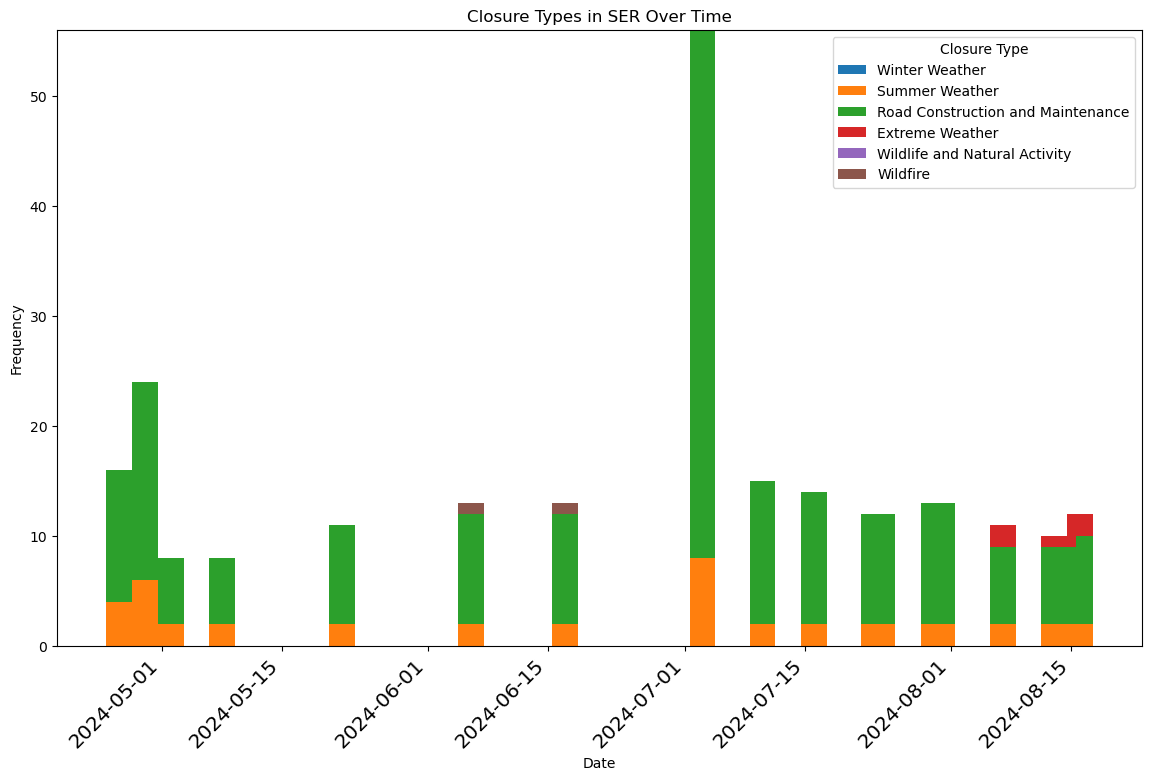

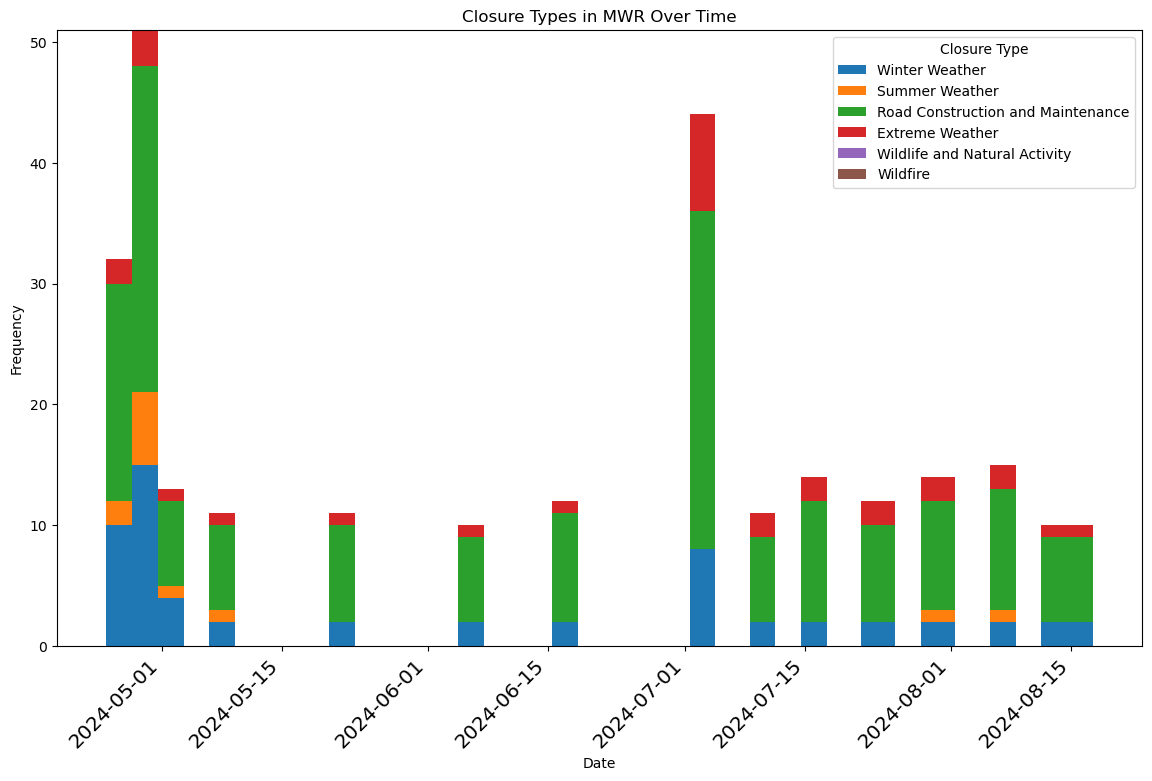

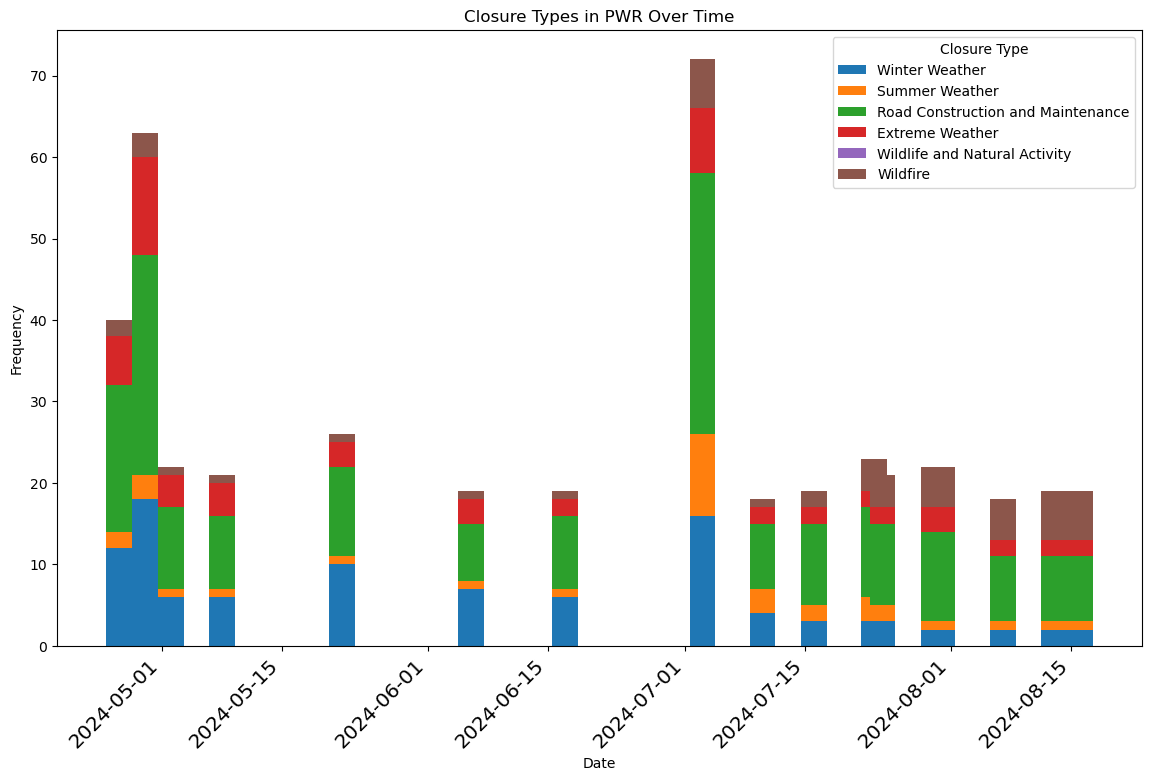

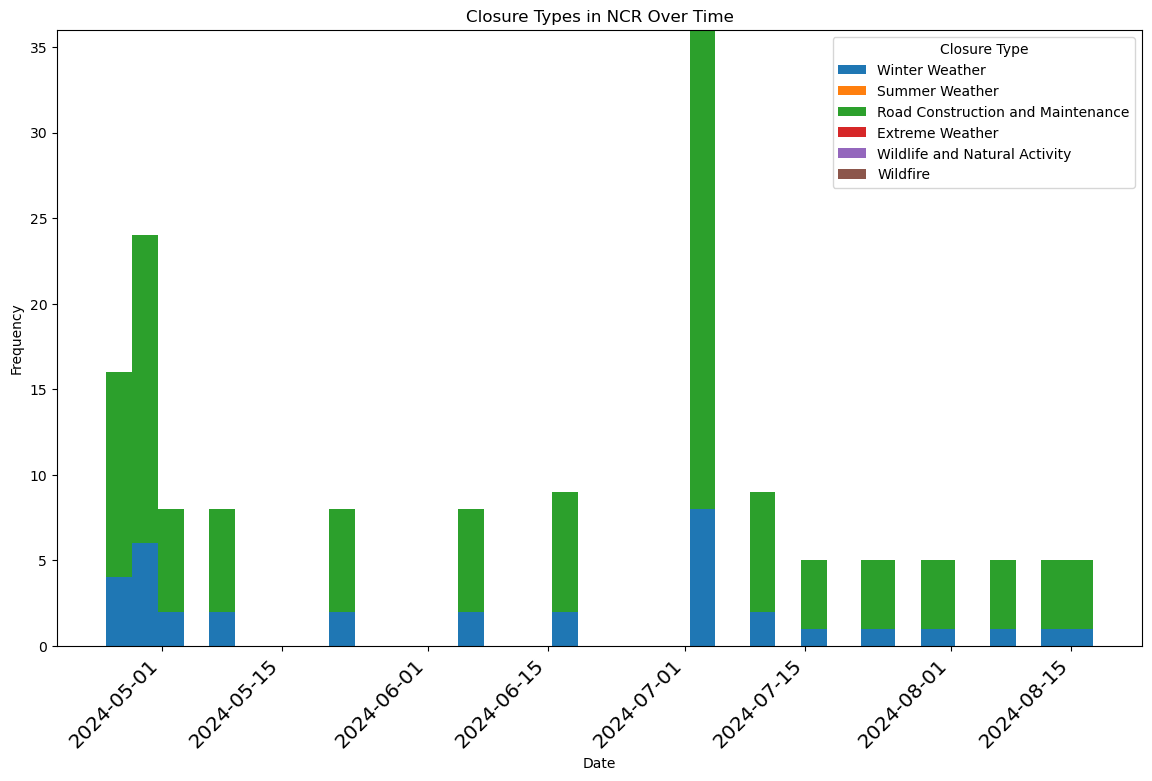

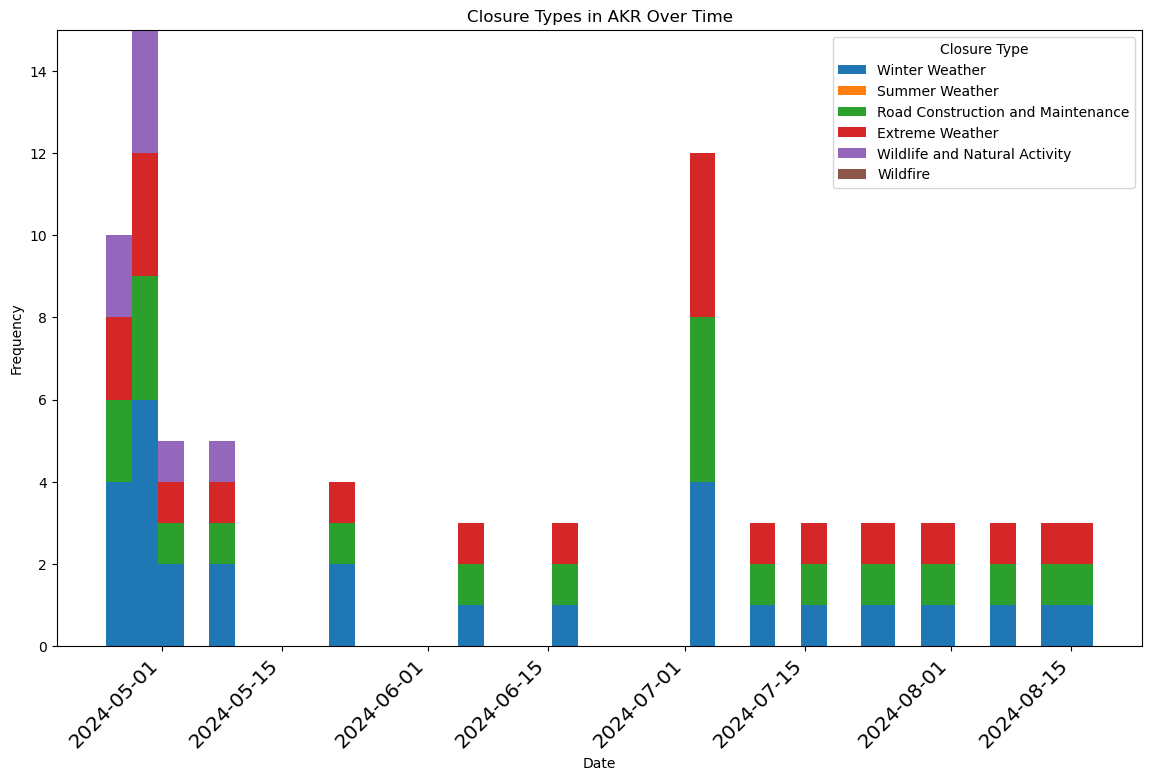

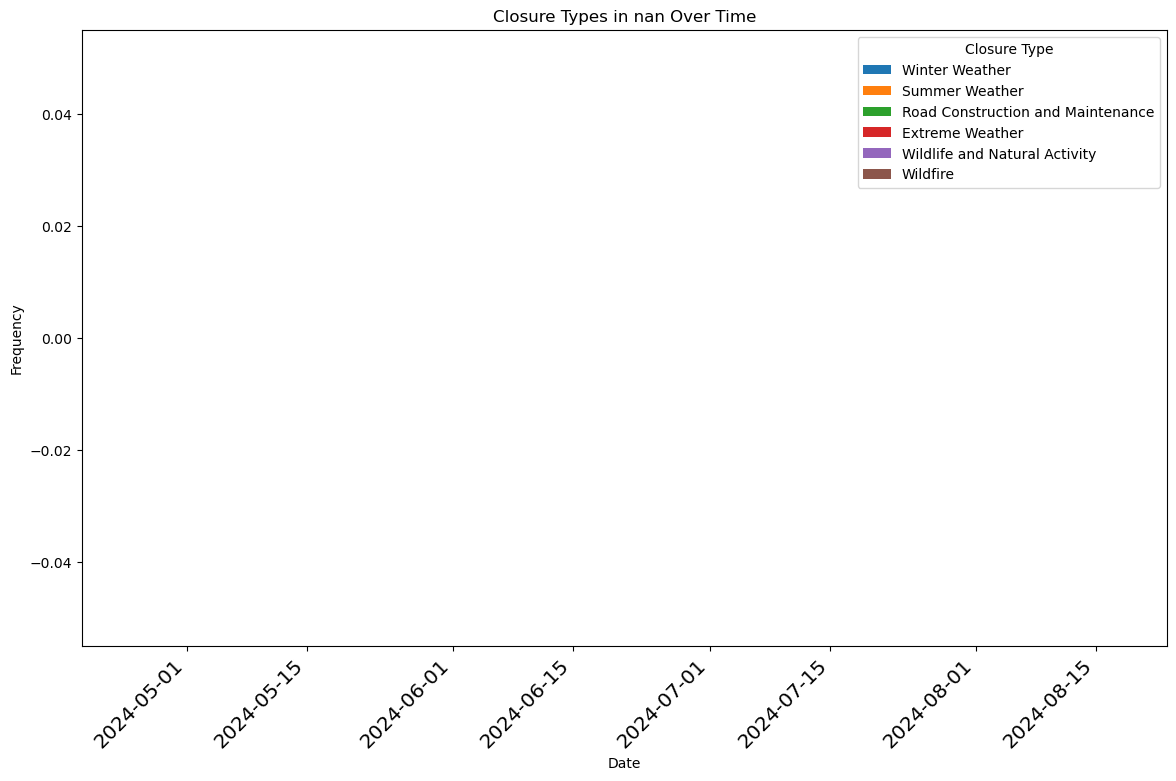

In [2]:
# Define the keyword sets
keyword_sets = {
    'Winter Weather': ['snow', 'ice', 'sleet', 'blizzard', 'frost', 'freeze'],
    'Summer Weather': ['heat', 'hot', 'humid', 'drought', 'sun', 'warm'],
    'Road Construction and Maintenance': ['construction', 'repair', 'paving', 'closure', 'detour', 'maintenance'],
    'Extreme Weather': ['storm', 'flood', 'tornado', 'hurricane', 'thunder', 'lightning', 'landslide', 'earthquake'],
    'Wildlife and Natural Activity': ['bear', 'deer', 'elk', 'bison', 'animal', 'wildlife'],
    'Wildfire': ['wildfire', 'fire']
}

# Ensure 'date' is in datetime format
alerts_df3['date'] = pd.to_datetime(alerts_df3['date'],format='mixed')

# Initialize a dictionary to store frequency counts for each keyword set by park region
keyword_freqs = {
    category: {region: {'date': [], category: []} 
               for region in alerts_df3['Reg'].unique()}
    for category in keyword_sets
}

alerts_df3['description'] = alerts_df3['description'].astype(str).str.lower()

# Iterate through the DataFrame
for i, row in alerts_df3.iterrows():
    date = row['date']
    region = row['Reg']
    description = row['description'].lower()
    
    for category, keywords in keyword_sets.items():
        keyword_freqs[category][region]['date'].append(date)
        count = sum(1 for keyword in keywords if re.findall(keyword, description))
        keyword_freqs[category][region][category].append(count)

# Convert each keyword_freqs category and region dictionary to a DataFrame
keyword_dfs = {
    category: {region: pd.DataFrame(data) 
               for region, data in regions.items()} 
    for category, regions in keyword_freqs.items()
}

# Merge all category DataFrames for each region
merged_dfs = {}
for region in alerts_df3['Reg'].unique():
    merged_df = pd.DataFrame({'date': keyword_dfs['Winter Weather'][region]['date']})
    for category in keyword_sets:
        merged_df[category] = keyword_dfs[category][region][category]
    merged_dfs[region] = merged_df.groupby('date').sum().reset_index()

# Create the directories if they don't exist
output_dir = 'Figures/Individual Regions'
os.makedirs(output_dir, exist_ok=True)

# Plotting stacked bar charts for each region
for region, df in merged_dfs.items():
    plt.figure(figsize=(14, 8))
    bottom = pd.Series([0] * len(df))
    for category in keyword_sets:
        plt.bar(df['date'], df[category], bottom=bottom, label=category, width=3)
        bottom += df[category]
    
    plt.title(f'Closure Types in {region} Over Time')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend(title='Closure Type')
    plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)
    output_path = os.path.join(output_dir, str(region) + 'Closures Over time.png')
    plt.savefig(output_path, dpi=150, bbox_inches='tight')
    plt.show()